In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 2.9 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=735b38b7d783744b5f92848d590ee40d734ff933da0871a12e436eb48eccf197
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F


import medmnist
from medmnist import INFO, Evaluator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is 3. notebook for RetinaMNIST Dataset (3 canals)<br>
5 clases <br>train: 1080<br>val: 120<br>test: 400


In [ ]:
#selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


#Loading dataset

In [ ]:
data_flag = 'retinamnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 100
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5],)#,
    #transforms.Grayscale(num_output_channels=1)
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/3291041 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


#Info + samples

In [ ]:
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'task': 'ordinal-regression',
 'label': {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'},
 'n_channels': 3,
 'n_samples': {'train': 1080, 'val': 120, 'test': 400},
 'license': 'CC BY 4.0'}

In [ ]:
label_array_train = []
for (data, labels) in train_dataset:
  label_array_train.append(labels)
index_values = np.arange(1, len(label_array_train)+1)
column_values = ['class']
  
# creating the train dataframe
df_train = pd.DataFrame(data = label_array_train, 
                  index = index_values, 
                  columns = column_values)

label_array_val = []
for (data, labels) in val_dataset:
  label_array_val.append(labels)
index_values = np.arange(1, len(label_array_val)+1)
column_values = ['class']
  
# creating the val dataframe
df_val = pd.DataFrame(data = label_array_val, 
                  index = index_values, 
                  columns = column_values)

label_array_test = []
for (data, labels) in test_dataset:
  label_array_test.append(labels)
index_values = np.arange(1, len(label_array_test)+1)
column_values = ['class']
  
# creating the test dataframe
df_test = pd.DataFrame(data = label_array_test, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
train_size_arange = np.arange(1, len(label_array_train)+1)
train_1 = sum(df_train["class"]==1)
train_0 = sum(df_train["class"]==0)
train_2 = sum(df_train["class"]==2)
train_3 = sum(df_train["class"]==3)
train_4 = sum(df_train["class"]==4)


val_size_arange = np.arange(1, len(label_array_val)+1)
val_1 = sum(df_val["class"]==1)
val_0 = sum(df_val["class"]==0)
val_2 = sum(df_val["class"]==2)
val_3 = sum(df_val["class"]==3)
val_4 = sum(df_val["class"]==4)

test_size_arange = np.arange(1, len(label_array_test)+1)
test_1 = sum(df_test["class"]==1)
test_0 = sum(df_test["class"]==0)
test_2 = sum(df_test["class"]==2)
test_3 = sum(df_test["class"]==3)
test_4 = sum(df_test["class"]==4)

In [ ]:
import plotly.graph_objects as go
sets=['Train Dataset', 'Val Dataset', 'Test Dataset']
fig = go.Figure(data=[
    go.Bar(name='0_level', x=sets, y=[train_0, val_0, test_0]),
    go.Bar(name='1_level', x=sets, y=[train_1, val_1, test_1]),
    go.Bar(name='2_level', x=sets, y=[train_2, val_2, test_2]),
    go.Bar(name='3_level', x=sets, y=[train_3, val_3, test_3]),
    go.Bar(name='4_level', x=sets, y=[train_4, val_4, test_4])
    ]
    )
fig.update_layout(title="Quantity of samples over sets", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))

fig.update_yaxes(title_text='Quantity')
fig.show()

**1) Real OCT of iris**

<img src="https://drive.google.com/uc?export=view&id=1h6k1bnTvs2y3bHMrTgOpKDClN6wer1HP" width=400></img>


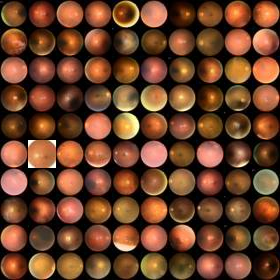

In [ ]:
train_dataset.montage(length=10)

#CNN model

In [ ]:
# model class for pneumonia prediction
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv1_bn=nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv2_bn=nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv3_bn=nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.conv4_bn=nn.BatchNorm2d(128)

        # self.conv5 = nn.Conv2d(128, 180, 3, 1)
        # self.conv5_bn=nn.BatchNorm2d(180)

        self.fc1 = nn.Linear(7*7*128, 800) #((((28-2)/2)-2)/2) = 5,..
        self.fc1_bn=nn.BatchNorm1d(800)

        self.fc2 = nn.Linear(800, 300)
        self.fc2_bn=nn.BatchNorm1d(300)

        self.fc3 = nn.Linear(300, 60)
        self.fc3_bn=nn.BatchNorm1d(60)

        self.fc4 = nn.Linear(60, 2)


    def forward(self, X):
        X = self.conv1(X)
        X = F.relu(self.conv1_bn(X))  #1

        X = F.max_pool2d(X, 2, 2)

        X = self.conv2(X)
        X = F.relu(self.conv2_bn(X))

        X = self.conv3(X)
        X = F.relu(self.conv3_bn(X))  #3

        X = self.conv4(X)
        X = F.relu(self.conv4_bn(X))  #4

        # X = self.conv5(X)
        # X = F.relu(self.conv5_bn(X))  #4

        X = X.view(-1, 7*7*128)

        X = self.fc1(X)
        X = F.relu(self.fc1_bn(X))
        X = self.fc2(X)
        X = F.relu(self.fc2_bn(X))
        X = self.fc3(X)
        X = F.relu(self.fc3_bn(X))
        X = self.fc4(X)
        return F.sigmoid(X) #for binary class.
        #softmax(X, dim=1)

In [ ]:
model = ConvolutionalNetwork().to(device)
loss_function = nn.BCELoss() #for binary class.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

#Training

In [ ]:
def get_accuracy(model, test_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for (data, labels) in test_loader:
          net_out = model(data) 
          predicted_labels = []
          for row in net_out:
            predicted_labels.append(torch.argmax(row))

          for i, object in enumerate(predicted_labels):
              if predicted_labels[i] == labels[i]:
                correct += 1
              total += 1
  return correct/total

In [ ]:
min_valid_loss = np.inf
MODELPATHAGE = "/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_retina.pth"

historical_train_loss = []
historical_validation_loss = []
epochs = []
i = 0
best_acc = 0

for epoch in range(NUM_EPOCHS):
  
  train_loss = 0.0

#  TRAINING
  for (data, labels) in train_loader:
    labels_1hot_t = []
    optimizer.zero_grad()  #cleaning previous gradients
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_t.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_t))
    loss.backward()  #backward pass
    optimizer.step()  #updating weights
    train_loss += loss.item()
    histloss = loss
    i+=1

#  VALIDATION
  validation_loss = 0.0
  model.eval() 

  for (data, labels) in val_loader:
    labels_1hot_v = []
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_v.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_v))
    validation_loss += loss.item()
    hisvloss = loss

  historical_train_loss.append(histloss)
  historical_validation_loss.append(hisvloss)

#  TESTING
  acc = get_accuracy(model, test_loader)
  if acc > best_acc:
    best_acc = acc
    model.to(device)
    torch.save(model, MODELPATHAGE)

  epochs.append(epoch+1)

  print(f'Epoch {epoch + 1}. len: {len(train_loader)}\n\
  Training loss: {round(train_loss,4)}\n\
  Validation loss: {round(validation_loss,4)}\n\
  Accuracy: {round(acc*100,4)}%\n')